# 予定

- ~~note8: 学習データとは別の波形のシミュレーションができるか確かめる~~
- note9: 定常状態のデータだけで学習させる
- gru-note1: GRU　実装してみる


# やること

目視でおよそ定常である波形を10周期分使って学習する


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [57]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self, h: torch.Tensor, v_s: torch.Tensor, u: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # h: [batch, 2] - [i_L, v_C]

        i_L = h[:, 0]
        v_C = h[:, 1]

        v_s_t = torch.as_tensor(v_s, dtype=i_L.dtype, device=i_L.device)
        u_t = torch.as_tensor(u, dtype=i_L.dtype, device=i_L.device)
        v_p = v_s_t * u_t

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # DCM対応
        v_a = torch.where((v_p == 0) & (i_L <= 0), v_C, v_p)

        # オイラー法
        i_L_next = i_L + (self.dt / L) * (v_a - v_C)
        i_L_next = torch.relu(i_L_next)  # 電流は負にならない（DCM考慮）

        v_C_next = v_C + (self.dt / C) * (i_L - v_C / R)

        return torch.stack([i_L_next, v_C_next], dim=1), v_a

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

# BuckConverterCell を使ってシミュレーションデータを作成


In [58]:
# 真値パラメータ（すべてのデータセットで共通）
L_true = 100e-6
C_true = 48e-6
R_true = 10

dt = 5e-7
Vin = 28
Vref = 6
duty = Vref / Vin

Tsim = 0.01  # シミュレーション時間(s)
steps = int(Tsim / dt)  # サンプリング数
f_sw = 20e3  # スイッチング周波数
period = int(1 / f_sw / dt)  # 1周期あたりのサンプル数
print(f"1周期あたりのサンプル数: {period}")
print(f"Duty: {duty}")

# スイッチング信号
u = np.zeros(steps)
for j in range(steps):
    u[j] = 1 if j % period < period * duty else 0

# 入力電圧
v_s = np.ones(steps) * Vin

# モデルを作成
model_true = BuckConverterCell(dt=dt, L_init=L_true, C_init=C_true, R_init=R_true)

va_list = []
il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    for j in range(steps):
        # 現在の状態を保存
        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

        h_current, va = model_true(h_current, v_s[j], u[j])
        va_list.append(va[0].item())


va = torch.tensor(np.array(va_list), dtype=torch.float32).unsqueeze(1)
iL = torch.tensor(np.array(il_list), dtype=torch.float32)
vC = torch.tensor(np.array(vc_list), dtype=torch.float32)

print(va.shape)
print(iL.shape)
print(vC.shape)


1周期あたりのサンプル数: 100
Duty: 0.21428571428571427
torch.Size([20000, 1])
torch.Size([20000])
torch.Size([20000])


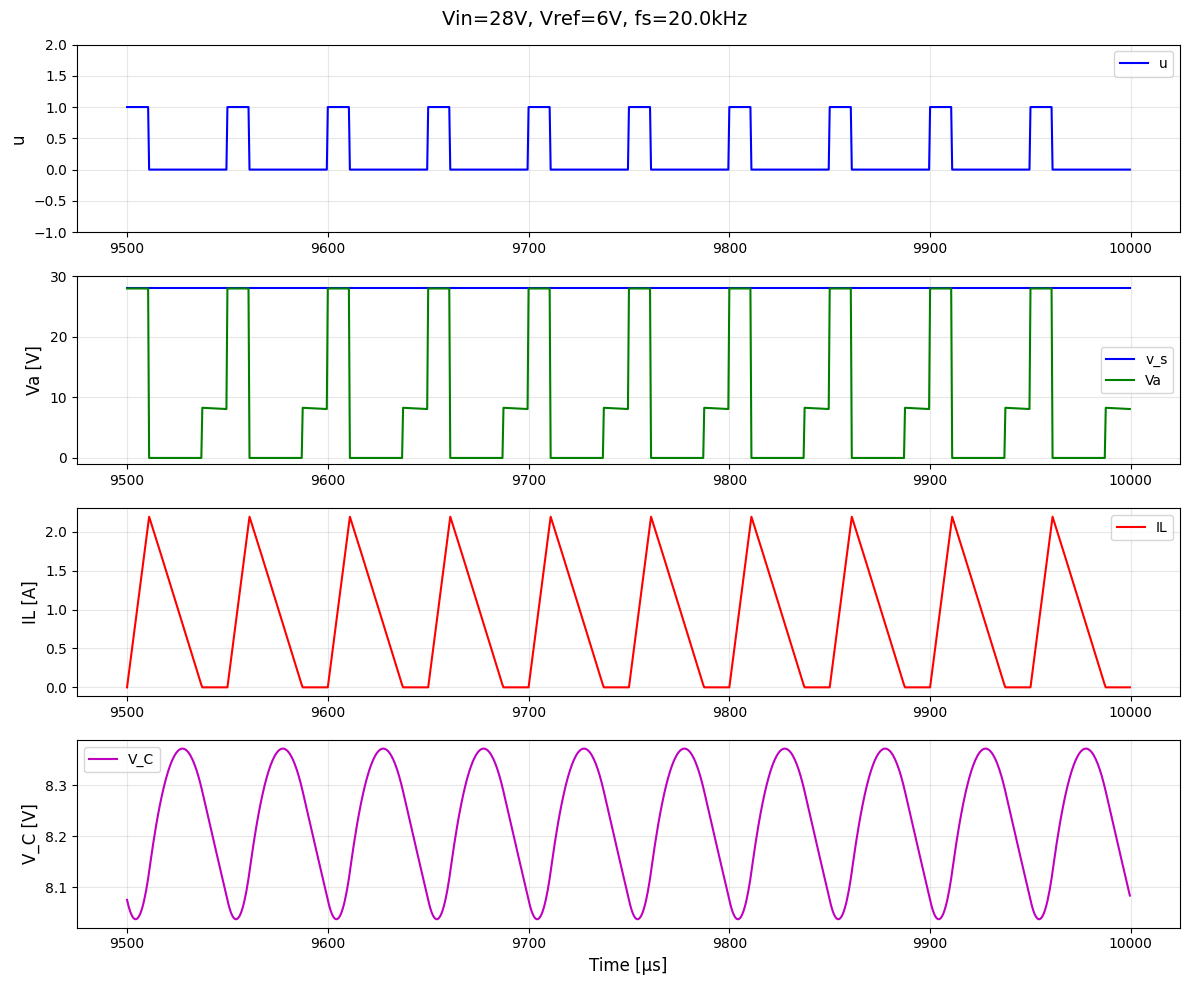

In [59]:
# 生成したデータセットのサンプルを可視化
plot_range = 1000


fig, axes = plt.subplots(4, 1, figsize=(12, 10))
t = np.arange(0, steps) * dt

# タイトル
fig.suptitle(
    f"Vin={Vin}V, Vref={Vref}V, fs={f_sw / 1e3:.1f}kHz",
    fontsize=14,
)

# u
axes[0].plot(t[-plot_range:] * 1e6, u[-plot_range:], "b-", linewidth=1.5, label="u")
axes[0].set_ylabel("u", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 2)
axes[0].legend()

# v_s
axes[1].plot(t[-plot_range:] * 1e6, v_s[-plot_range:], "b-", linewidth=1.5, label="v_s")
axes[1].set_ylabel("v_s [V]", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1, Vin + 2)
axes[1].legend()

# va (実効電圧、DCM対応)
axes[1].plot(
    t[-plot_range:] * 1e6,
    va[-plot_range:],
    "g-",
    linewidth=1.5,
    label="Va",
)
axes[1].set_ylabel("Va [V]", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1, Vin + 2)
axes[1].legend()

# il (インダクタ電流)
axes[2].plot(
    t[-plot_range:] * 1e6,
    iL[-plot_range:],
    "r-",
    linewidth=1.5,
    label="IL",
)
axes[2].set_ylabel("IL [A]", fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# vc (出力電圧)
axes[3].plot(
    t[-plot_range:] * 1e6,
    vC[-plot_range:],
    "m-",
    linewidth=1.5,
    label="V_C",
)
axes[3].set_ylabel("V_C [V]", fontsize=12)
axes[3].set_xlabel("Time [µs]", fontsize=12)
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()

# 学習


In [60]:
iL_train = iL[-1000:]
vC_train = vC[-1000:]
v_s_train = v_s[-1000:]
u_train = u[-1000:]

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 1e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 200

model = BuckConverterCell(dt=dt, L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}

# 学習データの準備 - 次ステップ予測のためのペアを作成
h_seq = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)  # 現在の状態
h_target = torch.stack([iL_train[1:], vC_train[1:]], dim=1)  # 次時刻の状態


# 学習ループ
for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred, _ = model(h_seq, v_s_train[:-1], u_train[:-1])
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={R_true:.1f})"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Loss={loss.item():.6e}  "
        f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
        f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
        f"R={params['R']:.2f}Ω (true={R_true:.1f})"
    )


Epoch 0: Loss=3.950118e-04  L=198.0µH (true=100.0)  C=99.0µF (true=48.0)  R=8.16Ω (true=10.0)
Epoch 50: Loss=5.804748e-05  L=122.7µH (true=100.0)  C=60.8µF (true=48.0)  R=10.07Ω (true=10.0)
Epoch 100: Loss=9.657078e-08  L=99.2µH (true=100.0)  C=47.7µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 150: Loss=1.079491e-09  L=100.1µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
学習完了
Epoch 199: Loss=1.250901e-11  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)


# 結果


In [61]:
# シミュレーションしてみる
with torch.no_grad():
    h_sim = [torch.zeros(1, 2)]
    for t in range(1, steps):
        h_next, _ = model(h_sim[-1], v_s[t], u[t])
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

il_sim = h_sim[:, 0].numpy()
vc_sim = h_sim[:, 1].numpy()


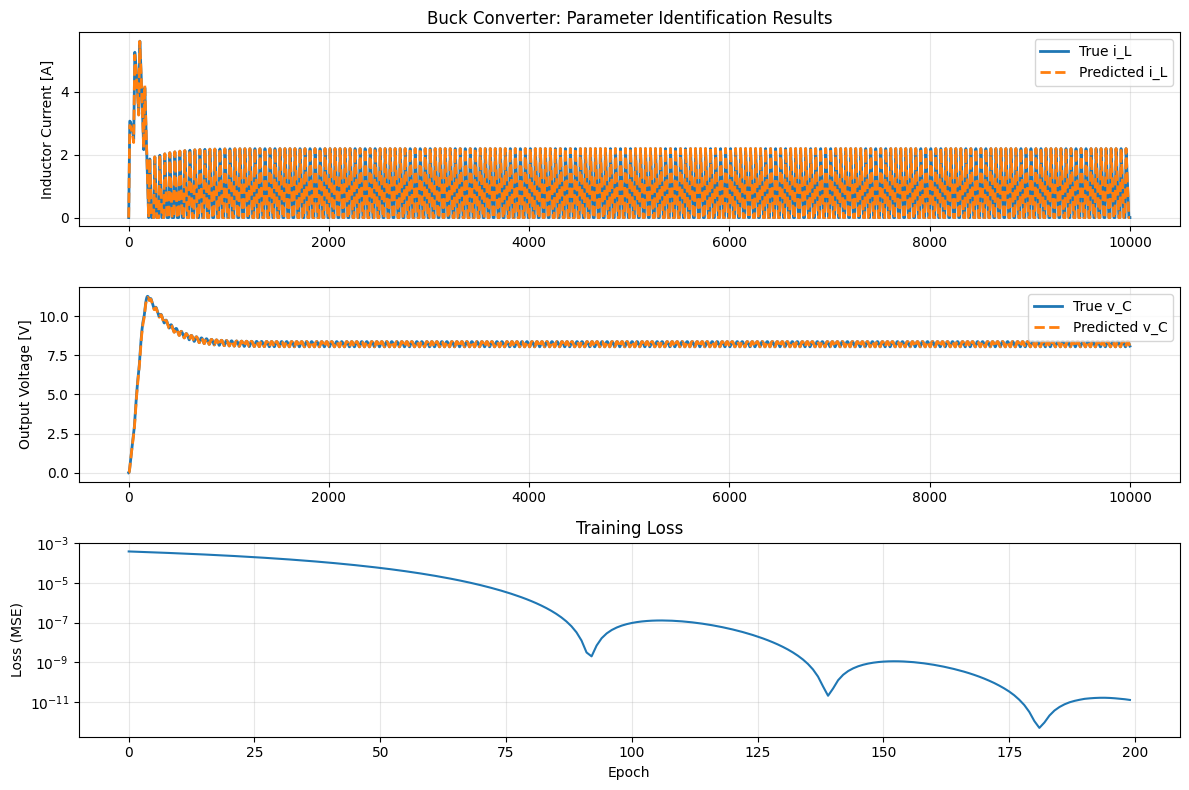

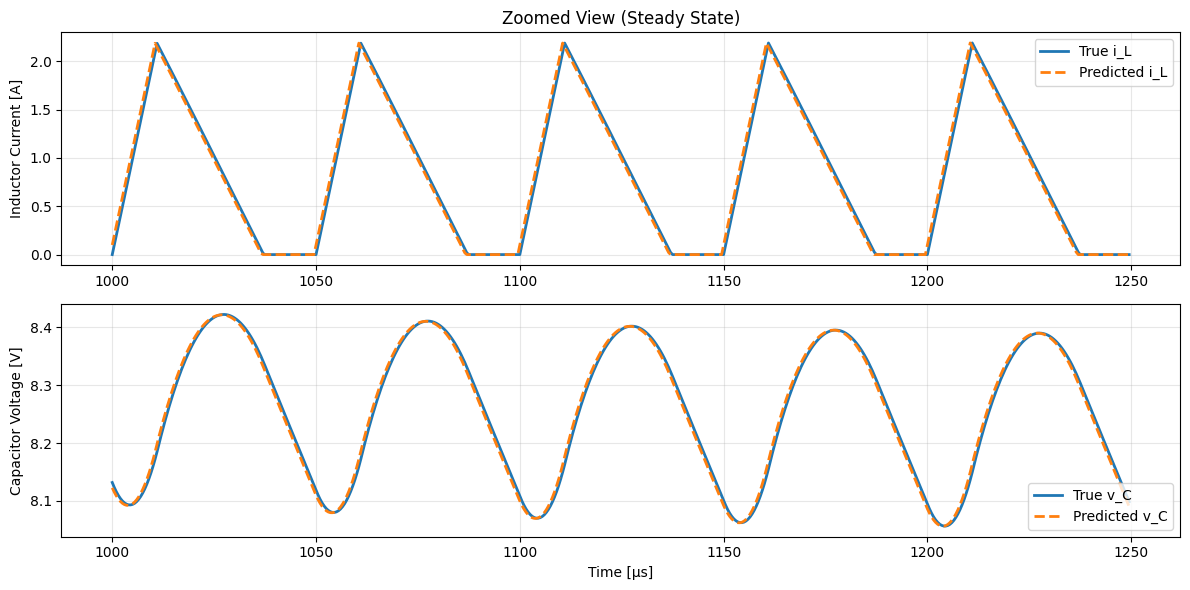

In [62]:
time = np.arange(steps) * dt * 1e6  # μs単位

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# インダクタ電流
axes[0].plot(time, iL, label="True i_L", linewidth=2)
axes[0].plot(time, il_sim, "--", label="Predicted i_L", linewidth=2)
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results")

# キャパシタ電圧
axes[1].plot(time, vC, label="True v_C", linewidth=2)
axes[1].plot(time, vc_sim, "--", label="Predicted v_C", linewidth=2)
axes[1].set_ylabel("Output Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴
axes[2].semilogy(loss_history)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training Loss")

plt.tight_layout()
plt.show()

# 一部区間の詳細表示
plt.figure(figsize=(12, 6))
start_idx = 2000
end_idx = 2500

plt.subplot(2, 1, 1)
plt.plot(time[start_idx:end_idx], iL[start_idx:end_idx], label="True i_L", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    il_sim[start_idx:end_idx],
    "--",
    label="Predicted i_L",
    linewidth=2,
)
plt.ylabel("Inductor Current [A]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Zoomed View (Steady State)")

plt.subplot(2, 1, 2)
plt.plot(time[start_idx:end_idx], vC[start_idx:end_idx], label="True v_C", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    vc_sim[start_idx:end_idx],
    "--",
    label="Predicted v_C",
    linewidth=2,
)
plt.ylabel("Capacitor Voltage [V]")
plt.xlabel("Time [µs]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

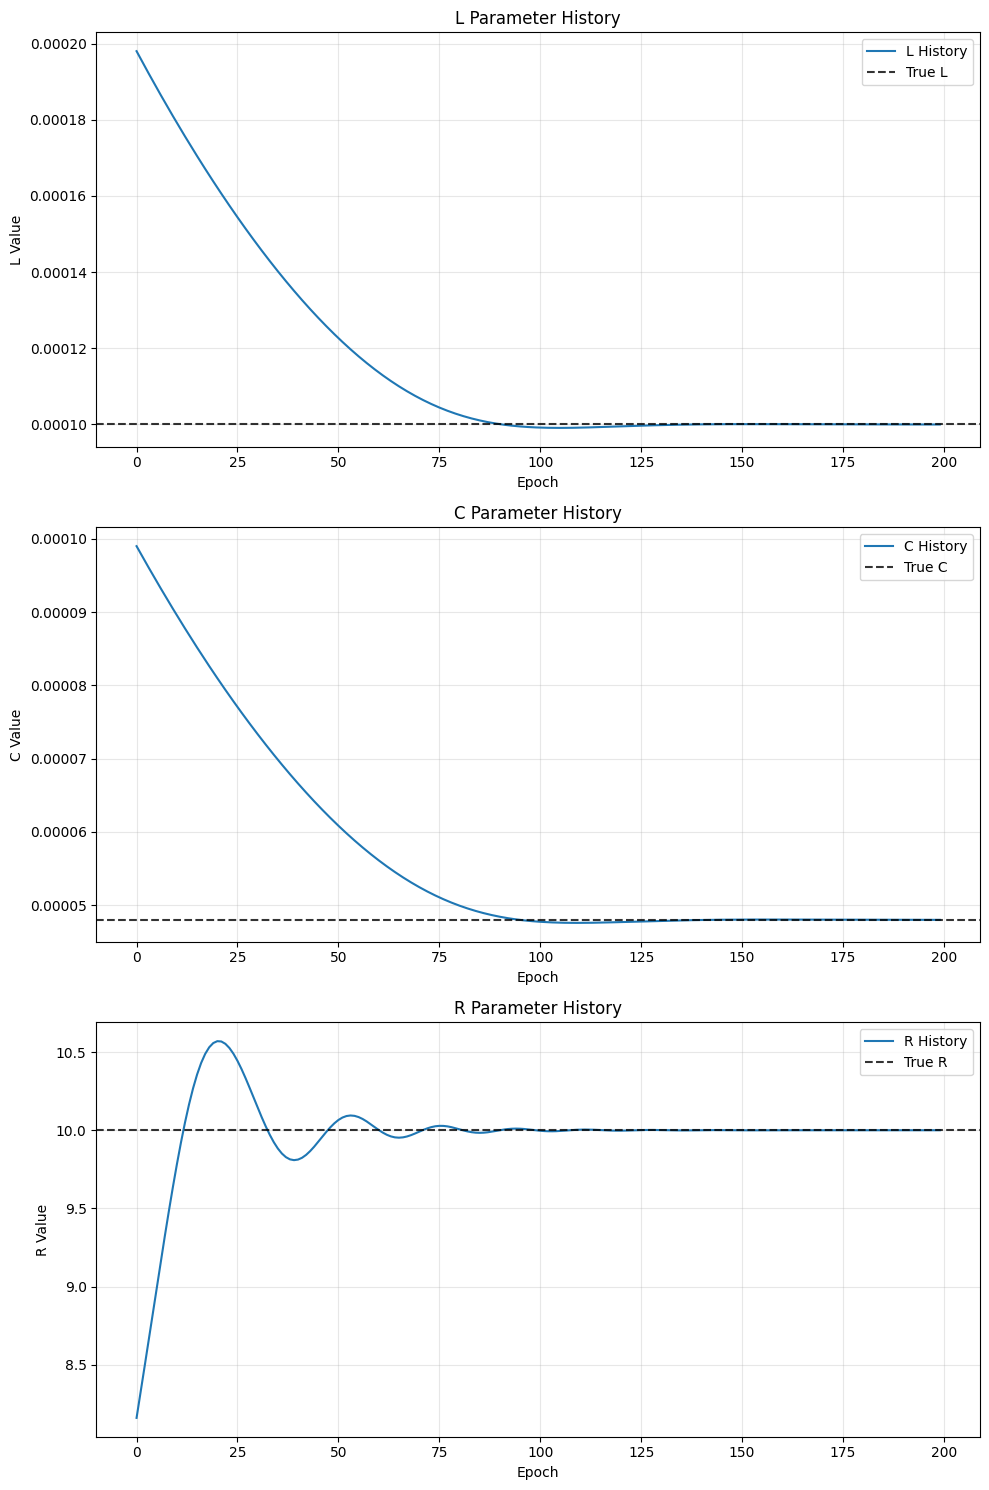

In [63]:
# 各パラメータの遷移
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=L_true, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=C_true, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=R_true, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()